In [15]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import pandas as pd
import scipy.stats
import seaborn as sns
from scipy.special import expit
from sklearn import linear_model, metrics
from sklearn.metrics import auc, plot_roc_curve, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from mapra import prep
from mapra.prep import save

sns.set_theme(style='white')
rng = np.random.default_rng(12345)


Notes?

In [16]:
importlib.reload(prep)
data = prep.dataset()
npr = data.fetch_numpy_distances()
spearman_rhos = data.fetch_spearman_rhos(npr)
delta_labels = data.order
rng = np.random.default_rng(12345)
'''
The first column indicates the metric,
the second the value,
the rest is the embedding diff
'''

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:41: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:52: UserWarning: found not exactly one TSV with annotations:
/home/quirin/PYTHON/mapra/wildtype_pHs.tsv
/home/quirin/PYTHON/mapra/prothermdb_annotations.tsv
/home/quirin/PYTHON/mapra/wildtypes.tsv
/home/quirin/PYTHON/mapra/txts/uniprot_to_pdb.tsv
/home/quirin/PYTHON/mapra/txts/uniprot_to_pdb_unmapped.tsv
/home/quirin/PYTHON/mapra/full_dbs/crop.tsv
/home/quirin/PYTHON/mapra/full_dbs/wild_types.tsv
/home/quirin/PYTHON/mapra/full_dbs/wildtypes.tsv
  warnings.warn('found not exactly one TSV with annotations:\n' + '\n'.join(str(tsv) for tsv in tsvs))


reading /home/quirin/PYTHON/mapra/all_sequences_prothermdb_HALF.h5 ...
read 8113 embeddings for 323 proteins, each SAV with 0 neighbors on each side, wrote to /home/quirin/PYTHON/mapra/pkl/h5_slice_0.pkl


'\nThe first column indicates the metric,\nthe second the value,\nthe rest is the embedding diff\n'

### to show overfitting, loop either test_size or the number of selected columns, with rugplots

In [16]:
test_sizes = [ .1, 0]
column_numbers = [64, 1024]

if False:
    desc = '%d columns'
    params = column_numbers
    test_size = .2
else:
    desc = 'test size: %.1f'
    params = test_sizes
    n_columns = 1024

In [17]:
store = dict()
for row, param in enumerate(params):

    # sort out which one we're looping
    if desc.startswith('%d'):
        n_columns = param
    elif desc.startswith('t'):
        test_size = param
    else:
        assert False

    ars = list()
    all_cols = list()
    for i, delta in enumerate(delta_labels):
        # select the rows for this delta, and cleave off the delta column
        dnpr = npr[npr[:, 0] == i, 1:]

        # # select the correct, best-fitting columns
        # rhos = abs(spearman_rhos[delta])
        # cols = np.argpartition(rhos, -n_columns)[-n_columns:]
        # all_cols.append(cols)
        #
        # # select the correct columns, shift because the measured value is in column 0
        # dnpr = dnpr[:, [0] + [c + 1 for c in cols]]

        # split into features and labels
        X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)

        if test_size:
            # split into test and training data
            X, X_test, y, y_true = train_test_split(
                X, y, test_size=test_size, random_state=35)
        else:
            # use the entire set for both training and testing -> over-fitting
            X, X_test, y, y_true = X, X, y, y

        print('\n')
        regr = linear_model.LassoLarsCV()
        # LassoCV(alphas=np.arange(.001, .1, .01))  # Lasso(alpha=0.01)
        regr.fit(X, y.flatten())
        cols = [i for i, c in enumerate(regr.coef_) if c > 0]
        all_cols.append(cols)
        print(f'{len(cols)} non-zero coefficients')
        print(regr.alpha_)

        # make a prediction
        y_pred = regr.predict(X_test).reshape(-1, 1)
        # save the prediction
        ars.append(np.hstack((np.full(y_pred.shape, i), y_pred, y_true)))
    store[row] = ars, all_cols
'done'



183 non-zero coefficients
0.0008189811595826077


126 non-zero coefficients
0.0005738100913633071


201 non-zero coefficients
0.0002559962753741417


40 non-zero coefficients
0.005451971106497191


31 non-zero coefficients
0.0025127707176875454


48 non-zero coefficients
0.0013800208717790123


'done'

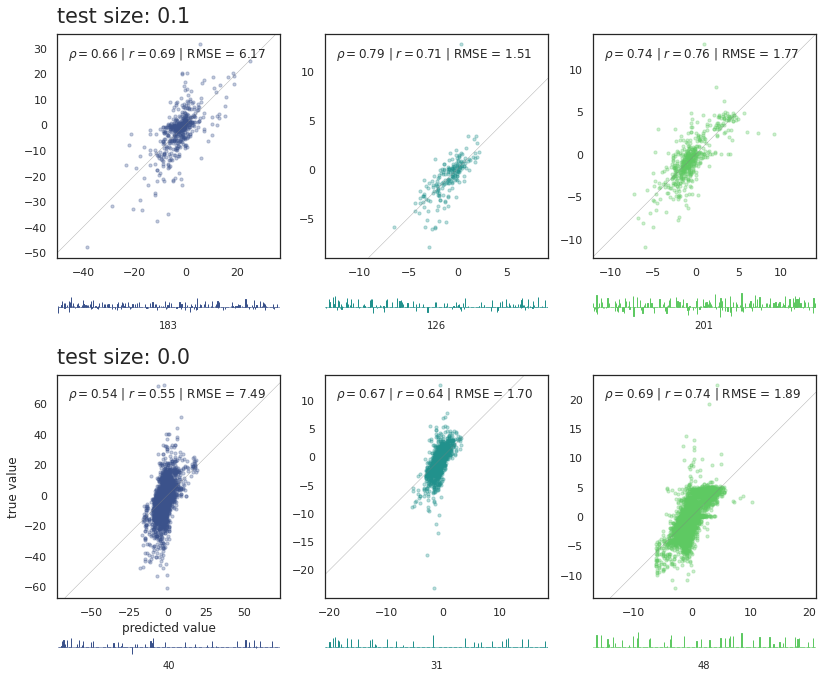

In [18]:
fig, axes = plt.subplots(2 * len(params), 3, figsize=(13.6, 6 * len(params)),
                         gridspec_kw={'height_ratios': [1, .25] * len(params), 'width_ratios': [1, 1, 1]})
cmap = sns.color_palette('viridis', 3)

for row, param in enumerate(params):
    ars, all_cols = store[row]

    for i, (ax, ax_cor, ar, delta, cols) in enumerate(
            zip(axes[2 * row, :], axes[2 * row + 1, :], ars, delta_labels, all_cols)):
        sns.regplot(ax=ax,
                    x=ar[:, 1], y=ar[:, 2],
                    color=cmap[i],
                    # marker='+',
                    scatter_kws={'s': 10, 'alpha': .3},
                    fit_reg=False, logistic=True)

        ax.set(aspect=1, box_aspect=1)
        # ax.set(title=data.tex_lookup[delta] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])
        ax.axline((0, 0), slope=1, lw=.5, color='.5', alpha=.6)

        # correlations
        sp, pval = scipy.stats.spearmanr(ar[:, 1:], axis=0)
        pcorr = np.corrcoef(ar[:, 1:], rowvar=False)[0, 1]
        rmse = mean_squared_error(ar[:, 2], ar[:, 1], squared=False)
        r2 = r2_score(ar[:, 2], ar[:, 1])

        # ax.text(.05, .7, data.tex_lookup[delta] + '\n'
        #         + r"$\rho = $" + f'{sp:.2f}, ' + r"$r = $" + f'{pcorr:.2f}\nRMSE = {rmse:.2f}\nr² = {r2:.2f}',
        #         transform=ax.transAxes)
        ax.text(.05, .9, r"$\rho = $" + f'{sp:.2f} | ' + r"$r = $" + f'{pcorr:.2f} | RMSE = {rmse:.2f}',
                transform=ax.transAxes)

        # ax_cor.axvline(x=512, lw=.5, color='.5', alpha=.8)
        ax_cor.bar(list(range(1024)), [co if idx in cols else 0 for idx, co in enumerate(spearman_rhos[delta])],
                   edgecolor=cmap[i], alpha=1)
        ax_cor.set_title(f'{len(cols)}', fontsize='small', pad=-40)
        ax_cor.set_xlim(-1, 1024)
        ax_cor.set_axis_off()
        ax_cor.set_ylim(-1, .5)

        axes[2 * row, 0].set_title(desc % param, loc='left', fontsize='xx-large', pad=12)

# fig.subplots_adjust(bottom=0.002)
axes[-2, 0].set(ylabel='true value', xlabel='predicted value')
save(fig, f'doooooof_lassolars_{desc % param}.png')

In [ ]:
for j in [3]:
    for ax in axes[j, :]:
        fig.delaxes(ax)
# axes[2, 0].set_title('train and test on full sets', loc='left', fontsize='xx-large', pad=12)
axes[2, 0].set_title('all 1024 columns', loc='left', fontsize='xx-large', pad=12)
# fig.tight_layout()
fig

In [ ]:
save(fig, f'linear_regr_{soll_size}_{desc % param}_noaxes.png')

In [ ]:
axes[2, 0].set_title('train and test on full sets')
fig

In [ ]:
axes[2, 0].set_title('all 1024 columns', loc='left', fontsize='xx-large', pad=12)
# save(fig, f'linear_regr_{desc % param}_noaxes.png')
fig


### make line plots showing the dependeny on the dataset size
number of columns, RMSE, Spearman's rho
alpha, r², Pearson's r
x: test size

In [19]:
npr

array([[ 0.0000e+00,  9.8984e+00, -9.8877e-02, ...,  2.8412e-02,
         3.3936e-02,  5.3711e-03],
       [ 0.0000e+00,  2.3008e+00,  1.5015e-02, ..., -3.9917e-02,
        -1.0040e-01, -1.1914e-01],
       [ 0.0000e+00,  3.5996e+00, -7.5806e-02, ...,  1.4893e-02,
        -1.6138e-01,  6.3477e-02],
       ...,
       [ 2.0000e+00, -8.9990e-01, -1.3513e-01, ..., -3.2227e-02,
        -1.0156e-01,  1.6956e-01],
       [ 2.0000e+00, -1.0996e+00, -1.3513e-01, ..., -3.2227e-02,
        -1.0156e-01,  1.6956e-01],
       [ 2.0000e+00,  9.9976e-02, -1.3513e-01, ..., -3.2227e-02,
        -1.0156e-01,  1.6956e-01]], dtype=float16)

In [17]:
def make_splits(npr, seed=rng.integers(low=0, high=1000, size=1)[0]):
    print(f'split seed {seed}')
    # create validation sets
    splits = dict()
    test_size = .2
    for i, delta in enumerate(delta_labels):
        # select the rows for this delta, and cleave off the delta column
        dnpr = npr[npr[:, 0] == i, 1:]
        # split into features and labels
        X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)
        # split into test and training data
        splits[delta] = train_test_split(
            X, y, test_size=test_size, random_state=seed)
        # X, X_test, y, y_true
    return splits

In [18]:
#make_splits(npr.copy(), 123456)

In [20]:
def dodo(splits, seed=rng.integers(low=0, high=1000, size=1)[0]):
    relative_dataset_sizes = np.arange(.05, 1.01, .05)
    rng.shuffle(relative_dataset_sizes)
    print(f'train seed {seed}')

    results = np.zeros((len(relative_dataset_sizes) * 3, 9))
    for row, set_size in enumerate(relative_dataset_sizes):
        for i, delta in enumerate(delta_labels):
            print(f'{row} {i} {delta} ', end='')

            X, X_test, y, y_true = splits[delta]

            # shuffle the dataset
            shared = np.hstack((y, X))
            rng.shuffle(shared)
            y, X = shared[:, 0].reshape(-1, 1), shared[:, 1:]

            # calculate number of leading rows to pick
            abs_set_size = int(max(1, np.round(set_size * X.shape[0])))
            print(f'dataset size: {abs_set_size} ', end='')
            X, y = X[:abs_set_size, :], y[:abs_set_size, :]

            regr = linear_model.LassoLarsCV(n_jobs=6)
            # LassoCV(alphas=np.arange(.001, .1, .01))  # Lasso(alpha=0.01)
            regr.fit(X, y.flatten())
            n_cols = len([i for i, c in enumerate(regr.coef_) if c > 0])
            n_cols = len(regr.active_)
            print(f'non-zero: {n_cols} alpha: {regr.alpha_}')

            # make a prediction
            y_pred = regr.predict(X_test).reshape(-1, 1)
            ar = np.hstack((y_pred, y_true))
            # evaluate the prediction
            sp, pval = scipy.stats.spearmanr(ar, axis=0)
            pcorr = np.corrcoef(ar, rowvar=False)[0, 1]
            rmse = mean_squared_error(y_true, y_pred, squared=False)
            r2 = r2_score(y_true, y_pred)

            results[row * 3 + i, :] = i, abs_set_size, n_cols, rmse, sp, pval, regr.alpha_, r2, pcorr

    np.save(str(Path('.').resolve().parent / 'txts' / f'{seed}_fresh.npy'), results)
    return results


In [23]:
results = [dodo(make_splits(npr.copy(), seed), seed) for seed in
           [0,1,2,3,4,5,6, 1024, 1025, 1026, 1027, 1028, 1029]]
'done'

'done'

In [22]:
ar = np.vstack(results)
np.save(str(Path('.').resolve().parent / 'txts' / f'optimize_valset_concat.npy'), ar)
ar

array([[0.00000000e+00, 3.26200000e+03, 2.90000000e+02, ...,
        1.45410854e-03, 3.95552070e-01, 6.32606747e-01],
       [1.00000000e+00, 1.24300000e+03, 2.55000000e+02, ...,
        6.94325871e-04, 3.41360833e-01, 6.21922373e-01],
       [2.00000000e+00, 3.22600000e+03, 3.72000000e+02, ...,
        2.97651439e-04, 5.46565256e-01, 7.39766343e-01],
       ...,
       [0.00000000e+00, 1.63100000e+03, 2.38000000e+02, ...,
        3.03253947e-03, 3.35964826e-01, 5.85542625e-01],
       [1.00000000e+00, 6.22000000e+02, 9.30000000e+01, ...,
        3.59071288e-03, 2.84349015e-01, 5.41694731e-01],
       [2.00000000e+00, 1.61300000e+03, 3.07000000e+02, ...,
        5.92585976e-04, 5.74349178e-01, 7.59696299e-01]])

In [ ]:
ar = np.vstack([np.load(str(Path('.').resolve().parent / 'txts'
                             / f'{seed}_new{suff}.npy')) for seed, suff in zip([0,1,2,3,4,5,6, 1024, 1025, 1026, 1027, 1028, 1029], [''] * 7 + ['est'] * 6)])
ar.shape


In [24]:
ar = np.load(str(Path('.').resolve().parent / 'txts' / f'optimize_valset_concat.npy'))
df = (pd.DataFrame(ar, columns=['delta', 'abs_set_size', 'n_cols', 'rmse', 'sp',
                                'pval', 'alpha', 'r2', 'pcorr'])
      .drop(columns=['pval'])
      .melt(id_vars=['delta', 'abs_set_size'], var_name='box', value_name='y'))
df

,delta,abs_set_size,box,y
0,0.0,3262.0,n_cols,290.000000
1,1.0,1243.0,n_cols,255.000000
2,2.0,3226.0,n_cols,372.000000
3,0.0,204.0,n_cols,31.000000
4,1.0,78.0,n_cols,10.000000
...,...,...,...,...
4675,1.0,233.0,pcorr,0.465154
4676,2.0,605.0,pcorr,0.714192
4677,0.0,1631.0,pcorr,0.585543
4678,1.0,622.0,pcorr,0.541695


/home/quirin/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


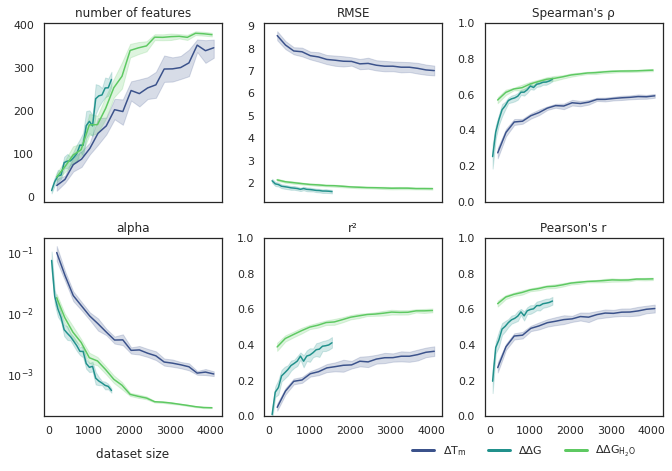

In [26]:
sns.set_theme(style='white')
cmap = sns.color_palette('viridis', 3)
import matplotlib.lines as mlines

relabel = lambda legend: [t.set_text(data.tex_lookup[t.get_text()]) for t in legend.texts]

g = sns.FacetGrid(data=df, col='box', col_wrap=3,
                  col_order=['n_cols', 'rmse', 'sp', 'alpha', 'r2', 'pcorr'],
                  height=3.2,
                  margin_titles=True, sharex=True, sharey=False)
g.map_dataframe(sns.lineplot, x='abs_set_size', y='y',
                hue='delta', hue_order=[0, 1, 2], palette=dict(enumerate(cmap)),
                markers=False, dashes=False)
# scatter_kws={'s': 10, 'alpha': .05})

# mess around with the legend
handles = list()
for de, co in zip(delta_labels, cmap):
    handles.append(mlines.Line2D([], [], color=co, label=data.tex_lookup[de], linewidth=3))

g.add_legend(title='', bbox_to_anchor=(.72, 0), ncol=3, handles=handles)
# g.set(xlim=(0, 1))

g.set_titles(col_template='{col_name}')
for ax, lab in zip(g.axes.flatten(), ['number of features', 'RMSE', 'Spearman\'s ρ',
                                      'alpha', 'r²', 'Pearson\'s r']):
    ax.set_title(lab)

for i, ax in enumerate(g.axes.flatten()):
    ax.set(box_aspect=1)
    # ax.set(xticks=[.2, .4, .6, .8])
    # Drawing the frame
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    if i in {2, 4, 5}:
        ax.set(ylim=(0, 1))

g.axes[3].set_yscale('log')
g.axes[3].set_xlabel('dataset size', labelpad=12)

# g.tight_layout()
# g.fig.subplots_adjust(hspace=-.1)
save(g, f'optimize_valset_shuffle.svg')
save(g, f'optimize_valset_shuffle.png')

### compare  to pairwise distances approach

In [3]:
npr_1024D = npr.copy()
npr_1024D
'''
The first column indicates the metric,
the second the value,
the rest is the embedding diff
'''

'\nThe first column indicates the metric,\nthe second the value,\nthe rest is the embedding diff\n'

In [7]:
importlib.reload(prep)
data = prep.dataset()
func = max
modify = 'pos'
mbeds = data.fetch_df_with_pairwise_distances(func=func, modify=modify, epsilon=0)  # mean or sum?
all_df, metric_labels = mbeds.data, mbeds.metric_labels
all_df

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:41: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:52: UserWarning: found not exactly one TSV with annotations:
/home/quirin/PYTHON/mapra/wildtype_pHs.tsv
/home/quirin/PYTHON/mapra/prothermdb_annotations.tsv
/home/quirin/PYTHON/mapra/wildtypes.tsv
/home/quirin/PYTHON/mapra/txts/uniprot_to_pdb.tsv
/home/quirin/PYTHON/mapra/txts/uniprot_to_pdb_unmapped.tsv
/home/quirin/PYTHON/mapra/full_dbs/crop.tsv
/home/quirin/PYTHON/mapra/full_dbs/wild_types.tsv
/home/quirin/PYTHON/mapra/full_dbs/wildtypes.tsv
  warnings.warn('found not exactly one TSV with annotations:\n' + '\n'.join(str(tsv) for tsv in tsvs))


reading /home/quirin/PYTHON/mapra/all_sequences_prothermdb_HALF.h5 ...
read 8113 embeddings for 323 proteins, each SAV with 0 neighbors on each side, wrote to /home/quirin/PYTHON/mapra/pkl/h5_slice_0.pkl


,delta,metric,dist,change
0,0,0,6.147786,9.90
1,0,0,4.140685,2.30
2,0,0,3.226287,3.60
3,0,0,3.282363,1.00
4,0,0,4.585520,5.60
...,...,...,...,...
36194,2,2,114.177961,0.60
36217,2,2,88.186723,1.65
36226,2,2,106.381724,0.89
36227,2,2,106.381724,1.07


In [8]:
metric = 'cosine'
# pick a metric and the columns: delta, change, features
npr_1D = np.array(all_df.loc[all_df.metric == metric_labels.index(metric),
                             ['delta', 'change', 'dist']])
npr_1D

array([[0.        , 9.9       , 0.25843573],
       [0.        , 2.3       , 0.2655862 ],
       [0.        , 3.6       , 0.12325473],
       ...,
       [2.        , 0.89      , 0.22317992],
       [2.        , 1.07      , 0.22317992],
       [2.        , 0.1       , 0.1454594 ]])

In [9]:
dfnow = pd.DataFrame(npr_1D, columns=['delta', 'change', 'dist'])
dfnow


,delta,change,dist
0,0.0,9.90,0.258436
1,0.0,2.30,0.265586
2,0.0,3.60,0.123255
3,0.0,1.00,0.136435
4,0.0,5.60,0.275879
...,...,...,...
4186,2.0,0.60,0.331973
4187,2.0,1.65,0.103685
4188,2.0,0.89,0.223180
4189,2.0,1.07,0.223180


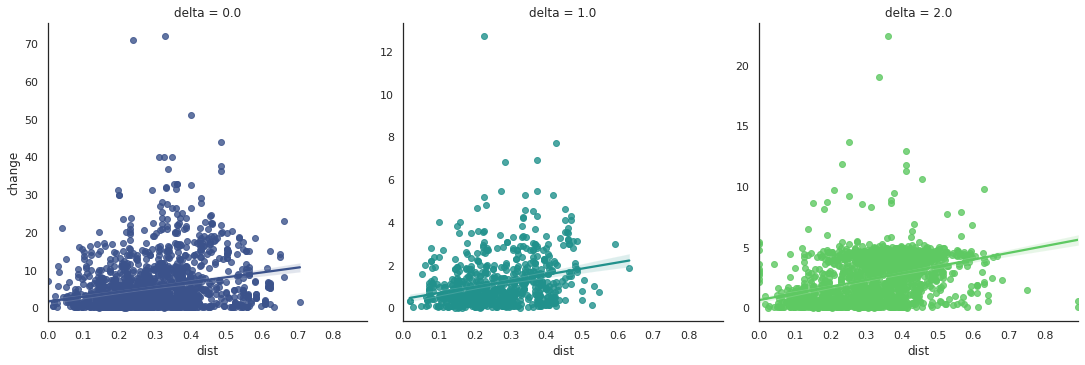

In [169]:
g = sns.lmplot(data=dfnow, x='dist', y='change', sharex=True, sharey=False,
               col='delta', hue='delta', hue_order=[0, 1, 2], palette='viridis')

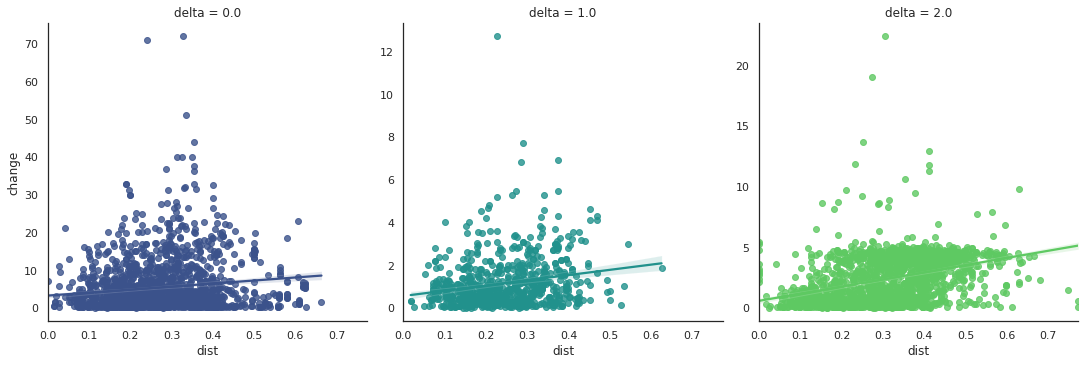

In [133]:
'np.mean pos cosine'
sns.lmplot(data=dfnow, x='dist', y='change', sharex=True, sharey=False,
           col='delta', hue='delta', hue_order=[0, 1, 2], palette='viridis')

In [13]:
# build regression with linear_model.LassoLarsCV()
test_size = .2
params = [npr_1024D, npr_1D]

store = dict()
for row, npr in enumerate(params):

    ars = list()
    all_cols = list()
    for i, delta in enumerate(delta_labels):
        # select the rows for this delta, and cleave off the delta column
        dnpr = npr[npr[:, 0] == i, 1:]

        # split into features and labels
        X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)

        # split into test and training data
        X, X_test, y, y_true = train_test_split(
            X, y, test_size=test_size, random_state=35)

        print('\n')
        regr = [linear_model.LassoLarsCV, linear_model.LinearRegression][row]()
        # LassoCV(alphas=np.arange(.001, .1, .01))  # Lasso(alpha=0.01)
        regr.fit(X, y.flatten())
        cols = [i for i, c in enumerate(regr.coef_) if c > 0]
        all_cols.append(cols)
        print(f'{len(cols)} non-zero coefficients')
        if not row:
            print(regr.alpha_)

        # make a prediction
        y_pred = regr.predict(X_test).reshape(-1, 1)
        # save the prediction
        ars.append(np.hstack((np.full(y_pred.shape, i), y_pred, y_true)))
    store[row] = ars, all_cols
'done'



189 non-zero coefficients
0.000890868607576765


180 non-zero coefficients
0.00041362876284923975


197 non-zero coefficients
0.00027489325648880395


1 non-zero coefficients


1 non-zero coefficients


1 non-zero coefficients


'done'

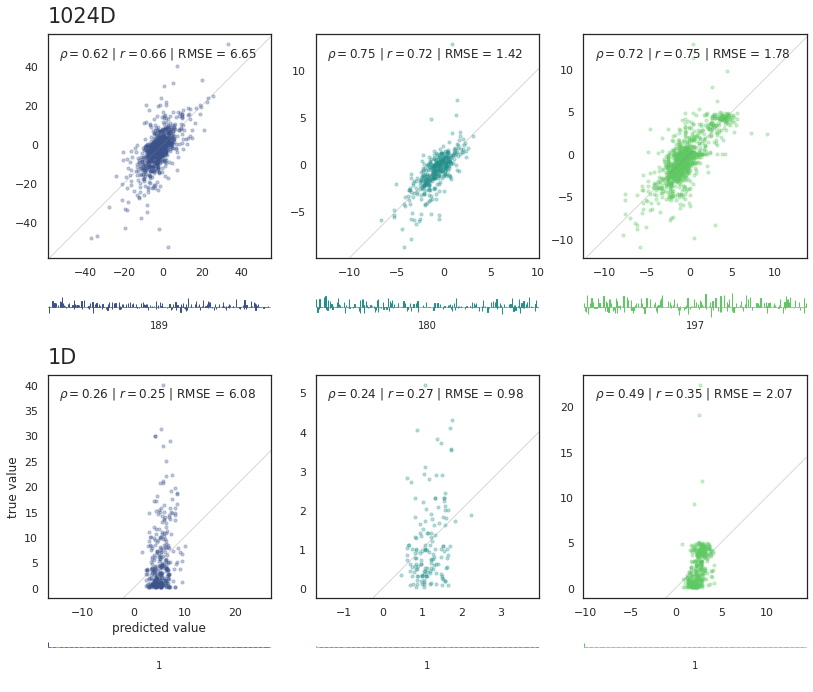

In [14]:
fig, axes = plt.subplots(2 * len(params), 3, figsize=(13.6, 6 * len(params)),
                         gridspec_kw={'height_ratios': [1, .25] * len(params), 'width_ratios': [1, 1, 1]})
cmap = sns.color_palette('viridis', 3)
params = ['1024D', '1D']

for row, param in enumerate(params):
    ars, all_cols = store[row]

    for i, (ax, ax_cor, ar, delta, cols) in enumerate(
            zip(axes[2 * row, :], axes[2 * row + 1, :], ars, delta_labels, all_cols)):
        sns.regplot(ax=ax,
                    x=ar[:, 1], y=ar[:, 2],
                    color=cmap[i],
                    # marker='+',
                    scatter_kws={'s': 10, 'alpha': .3},
                    fit_reg=False, logistic=True)

        ax.set(aspect=1, box_aspect=1)
        # ax.set(title=data.tex_lookup[delta] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])
        ax.axline((0, 0), slope=1, lw=.5, color='.5', alpha=.6)

        # correlations
        sp, pval = scipy.stats.spearmanr(ar[:, 1:], axis=0)
        pcorr = np.corrcoef(ar[:, 1:], rowvar=False)[0, 1]
        rmse = mean_squared_error(ar[:, 2], ar[:, 1], squared=False)
        r2 = r2_score(ar[:, 2], ar[:, 1])

        ax.text(.05, .9, r"$\rho = $" + f'{sp:.2f} | ' + r"$r = $" + f'{pcorr:.2f} | RMSE = {rmse:.2f}',
                transform=ax.transAxes)

        # ax_cor.axvline(x=512, lw=.5, color='.5', alpha=.8)
        ax_cor.bar(list(range(1024)), [co if idx in cols else 0 for idx, co in enumerate(spearman_rhos[delta])],
                   edgecolor=cmap[i], alpha=1)
        ax_cor.set_title(f'{len(cols)}', fontsize='small', pad=-40)
        ax_cor.set_xlim(-1, 1024)
        ax_cor.set_axis_off()
        ax_cor.set_ylim(-1, .5)

        axes[2 * row, 0].set_title(param, loc='left', fontsize='xx-large', pad=12)

# fig.subplots_adjust(bottom=0.002)
axes[-2, 0].set(ylabel='true value', xlabel='predicted value')
save(fig, f'1024D-1D_{param}.png')

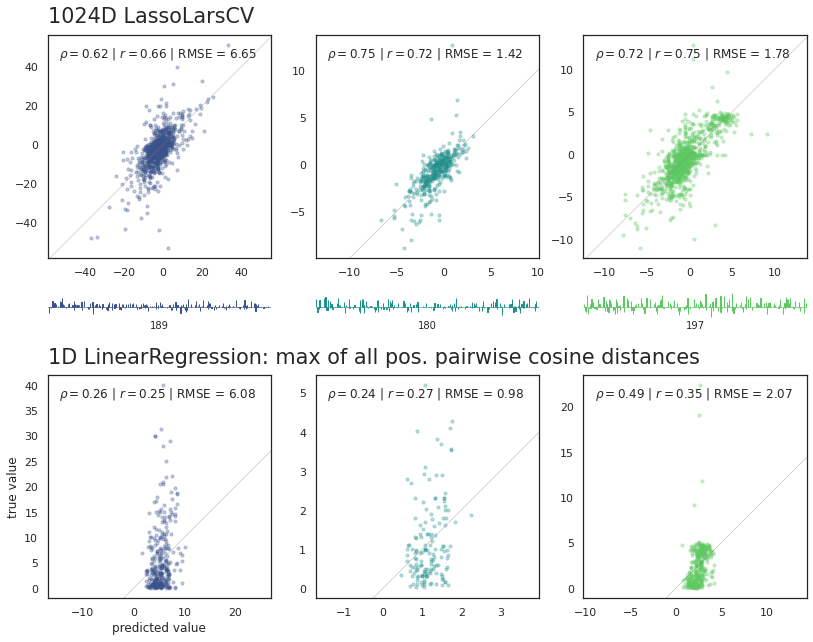

In [29]:
'this is not really working out ...'

for j in [3]:
    for ax in axes[j, :]:
        fig.delaxes(ax)
# axes[2, 0].set_title('train and test on full sets', loc='left', fontsize='xx-large', pad=12)
axes[0, 0].set_title('1024D LassoLarsCV', loc='left', fontsize='xx-large', pad=12)
axes[2, 0].set_title(f'1D LinearRegression: {func.__name__} of all {modify}. pairwise {metric} distances', loc='left',
                     fontsize='xx-large', pad=12)
# fig.tight_layout()
fig

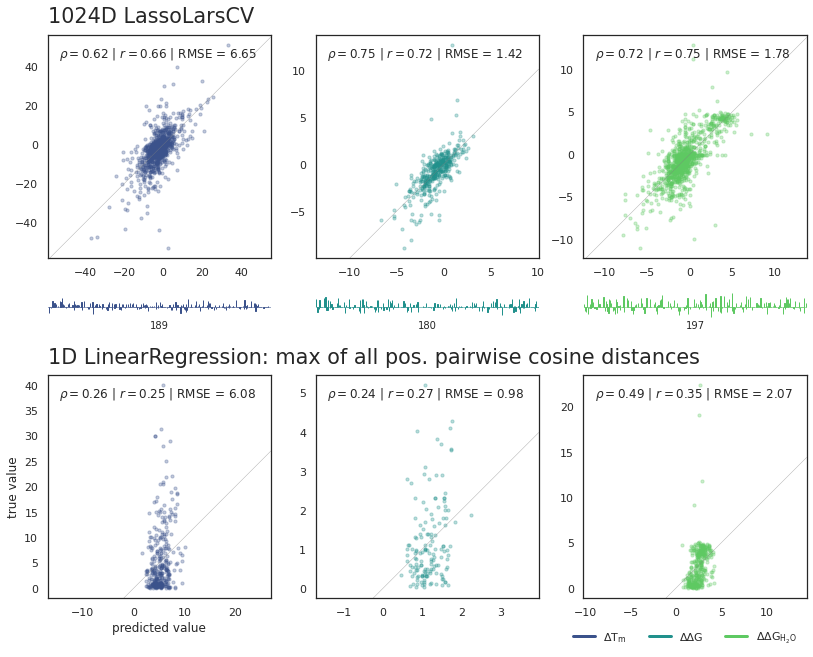

In [30]:
# mess around with the legend
handles = list()
for de, co in zip(delta_labels, cmap):
    handles.append(mlines.Line2D([], [], color=co, label=data.tex_lookup[de], linewidth=3))

fig.legend(title='', bbox_to_anchor=(.9, .2), ncol=3, handles=handles, frameon=False)
fig


In [32]:
save(fig, f'1024D-1D_{param}_noaxes.png')

In [124]:
func = np.mean
func.__name__


'mean'

## calculation process

In [ ]:
sns.set_theme()
rng = np.random.default_rng(12345)
from mapra.prep import save

In [ ]:
arshape = (2, 25)
ar = rng.integers(0, 10, arshape)
ar = rng.integers(0, 10, arshape)
diff = np.vstack((ar, ar[0, :], ar[0, :] - ar[1, :]))
diff


In [ ]:
mask = np.zeros_like(diff)
mask[2, :] = True
mask[:, 10:15] = True

f, ax = plt.subplots(figsize=(arshape[1] * .4, 2))
sns.heatmap(diff, mask=mask, annot=True, fmt='d',
            cmap='mako_r', cbar=False,
            ax=ax, square=True,
            # vmin=-20, vmax=20,
            linewidths=1,
            yticklabels=['$variant$', '$-wildtype$', '', '$=result$'],
            xticklabels=list(range(1, 11)) + [''] * 1 + ['.'] * 3 + [''] * 1 + list(range(1015, 1025)))
save(f, 'explainer.svg')

### now run the two cells above again to get the second matrix

In [ ]:
daff = diff.copy()

In [ ]:
daff

In [ ]:
res = np.vstack((daff[3, :], diff[3, :], np.zeros(arshape[1], dtype=int), daff[3, :] + diff[3, :]))
res

In [ ]:
g, axi = plt.subplots(figsize=(arshape[1] * .4, 2))
sns.heatmap(res, mask=mask, annot=True, fmt='d',
            cmap='mako_r', cbar=False,
            ax=axi, square=True,
            # vmin=-20, vmax=20,
            linewidths=1,
            yticklabels=['$E6D$', '$+A13P$', '', '$=result$'],
            xticklabels=list(range(1, 11)) + [''] * 1 + ['.'] * 3 + [''] * 1 + list(range(1015, 1025)))
save(g, 'summer.svg')


In [ ]:
seq = list('MDAMKRGLCCVLLLCGAVFVSPSQ')  #EIHARFRRGARSYQV')
seq[5] = 'E'
seq[12] = 'A'
seq = np.array(seq)
seqar = np.vstack((seq, seq))
seqar[1, 5] = 'D'
seqar[1, 12] = 'P'

seqar

In [ ]:
h, axj = plt.subplots(figsize=(arshape[1] * .4, 2))

maski = np.zeros_like(seqar, dtype=int)
maski[:, 5] = True
maski[:, 12] = True
seqm = np.zeros_like(seqar, dtype=int)
seqm[:, 5] = True
seqm[:, 12] = True
sns.heatmap(seqm, annot=seqar, alpha=maski, fmt='',
            cmap='mako_r', cbar=False,
            ax=axj, square=True,
            linewidths=1,
            yticklabels=['$wildtype$', 'E6D A13P $variant$'],
            xticklabels=list(range(1, len(seq) + 1)))
axj.xaxis.tick_top()
axj.tick_params(length=0)
save(h, 'seqs.svg')
